# Imports

In [1]:
import time
import serial
import sqlite3
import json
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import argrelextrema

# BiometricSignal Class

(array([], dtype=int64),)


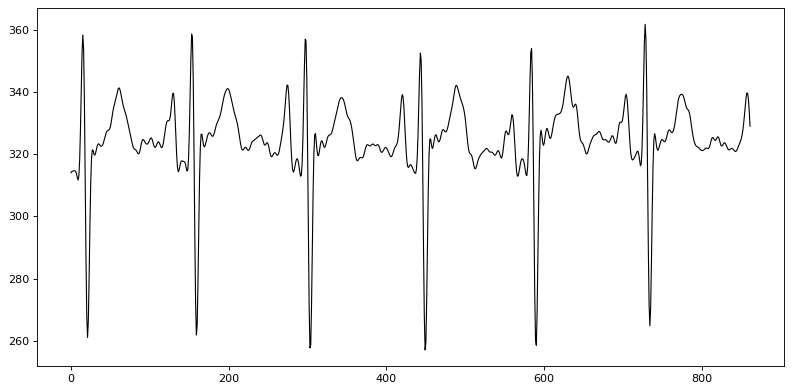

In [28]:
class BiometricSignal: 
    
#     captured_signal_csv = "./assets/subject_raw_ecg.csv"
    captured_signal_csv = "./subject2.csv"
#     captured_signal_csv = "./subject3a.csv"

    def __init__(self):
#         self.capture_signal = capture_signal()
        self.filtered_signal = []
        self.amended_signal = []
        self.r_peaks = []
        
        
    def capture_signal(self):
        serial_data = serial.Serial("/dev/ttyACM1", 9600)
        serial_list = []
        capture_time = 5
        t_end = time.time() + capture_time

        time.sleep(2)

        while time.time() < t_end:
            while serial_data.inWaiting() == 0:
                pass
            temp_string = serial_data.readline()
            serial_string = (
                str(temp_string)
                .replace("b", "")
                .replace("'", "")
                .replace("\\r", "")
                .replace("\\n", "")
            )
            if len(serial_string) == 3:
                serial_list.append(int(serial_string))
        return serial_list


    def output_signal_to_csv(self, serial_list):
        with open(BiometricSignal.captured_signal_csv, "w") as ecg_file:
            ecg_file.write("voltage,\n")
            for item in serial_list:
                ecg_file.write("%s,\n" % item)
            ecg_file.write("0,")


    def filter_captured_signal(self):
        numerator, denominator = signal.butter(4, 0.25, analog=False)
        data = pd.read_csv(BiometricSignal.captured_signal_csv)
        sig = data["voltage"]
        self.filtered_signal = signal.filtfilt(numerator, denominator, sig)
        return self.filtered_signal
    
    def amend_signal(self, filtered_signal):
#         threshold = 400
        start = 100
        end = -100
        self.amended_signal = filtered_signal[start:end]
        return self.amended_signal
    
    def find_r_peaks(self, filtered_signal, amended_signal):
        
        threshold = 400
#         start = 100
#         end = -100
        
#         amended_signal = amend_signal(filtered_signal)
        no_of_rows = amended_signal.shape[0]
        line_numbers = []
        theVoltage = []


        for i in range(0, no_of_rows):
            if amended_signal[i] > threshold:
                theVoltage.append(amended_signal[i])
            else:
                theVoltage.append(0)
            line_numbers.append(i)    


        ecg_plot = np.concatenate((theVoltage, line_numbers))

        self.r_peaks = argrelextrema(ecg_plot, np.greater, order=5)
        
        return self.r_peaks


# ----------------------------------------------------------------------------------------------
#                                       CODE FOR TESTING
# ----------------------------------------------------------------------------------------------
TEST_signal = BiometricSignal()
TEST_filtered_signal = TEST_signal.filter_captured_signal()
TEST_amended_signal = TEST_signal.amend_signal(TEST_filtered_signal)
TEST_r_peaks = TEST_signal.find_r_peaks(TEST_filtered_signal, TEST_amended_signal)

print(TEST_signal.r_peaks)

plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor="w", edgecolor="k")
plt.plot(TEST_amended_signal, color="#000000", linewidth=1)
# plt.axis('off')
# plt.savefig("project_presentation.png", dpi=150, quality=100, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Segment Class

In [3]:
class Segment:

    
    def __init__(self, bio_signal):
        self.bio_signal = bio_signal
        self.combined_seg = self.combining_segments()
        self.mean_segment = self.get_mean_of_segments()
        self.standardised_mean_segment = self.standardise_mean_segment()

# ----------------------------------------------------
# --------------Combining Segments -------------------
# ----------------------------------------------------
    def combining_segments(self):
        combined_seg_does_not_exist = True
        smallest_seg = None
        
        for i in range (0, 5):
            segment_start = self.bio_signal.r_peaks[0][i]
            segment_end = self.bio_signal.r_peaks[0][i+1]

            extracted_segment = self.bio_signal.amended_signal[segment_start:segment_end]
            if smallest_seg == None:
                smallest_seg = len(extracted_segment)
            elif (len(extracted_segment) < smallest_seg):
                smallest_seg = len(extracted_segment)

            if combined_seg_does_not_exist:
                combined_seg = np.zeros(len(extracted_segment) + 100)
                combined_seg_does_not_exist = False
            for j in range(0,len(extracted_segment)):
                combined_seg[j] =  combined_seg[j] + extracted_segment[j]
            
        combined_seg = np.trim_zeros(combined_seg)
        combined_seg = combined_seg[0:smallest_seg]
        return combined_seg
                

    def get_mean_of_segments(self):

        mean_segment = np.array([])
        
        for k in range (0, len(self.combined_seg)):
            mean_segment = np.append (mean_segment, self.combined_seg[k] / 5)
            
        return mean_segment

    
    def standardise_mean_segment(self):
        
        standardised_mean_segment = np.array([])
        
        min_of_mean_segment = min(self.mean_segment)
        for value in range(0, len(self.mean_segment)):
            standardised_mean_segment = np.append (standardised_mean_segment, self.mean_segment[value] - min_of_mean_segment)

        return standardised_mean_segment

        
# ----------------------------------------------------------------------------------------------
#                                       CODE FOR TESTING
# ----------------------------------------------------------------------------------------------
TEST_segment = Segment(TEST_signal)

print(type(TEST_segment.standardised_mean_segment))
# print(TEST_segment.combined_seg)
# TEST_combined_seg = TEST_segment.combining_segments()
# TEST_mean_segment = TEST_segment.get_mean_of_segments(TEST_combined_seg)
# TEST_standardised_mean_segment = TEST_segment.standardise_mean_segment(TEST_mean_segment)

# END OF SEGMENT CLASS

<class 'numpy.ndarray'>


# Features Class

In [4]:
class Features:
    
    def __init__(self, mean_segment):
        self.mean_segment = mean_segment
        self.features_lower = self.find_features_lower()
        self.features_higher = self.find_features_higher()
        
    def find_features_lower(self):
        features_lower = argrelextrema(self.mean_segment, np.less, order=5)
        self.features_lower = (features_lower[0],self.mean_segment[features_lower[0]])       
        return self.features_lower


    def find_features_higher(self):
        features_higher = argrelextrema(self.mean_segment, np.greater, order=5)
        self.features_higher = (features_higher[0],self.mean_segment[features_higher[0]]) 
        return self.features_higher

TEST_features = Features(TEST_segment.mean_segment)
# print(TEST_features.features_lower)
# print(TEST_features.features_higher)




# Templates Class

In [5]:
class Templates:
    
    def __init__(self, name):
        self.name = name
        self.conn = sqlite3.connect('templatesDB.db')
        self.c = self.conn.cursor()
        self.create_table()
        self.standardised_mean_segment = []
        self.featuresX = []
        self.featuresY = []
    
    def create_table(self):
        self.c.execute("""CREATE TABLE IF NOT EXISTS templates 
                                            ( name text,
                                                mean_segment text,
                                                featuresX text,
                                                featuresY text)""")
        self.conn.commit()
    
    
    def add_entry_to_database(self, features_lower, features_higher, standardised_mean_segment,
                          x_length, y_length):

        if self.does_user_exist(self.name) != True:
            thefeaturesLowerX = self.convert_features_to_percentages(features_lower[0].tolist(), x_length)
            thefeaturesLowerY = self.convert_features_to_percentages(features_lower[1].tolist(), y_length)
            thefeaturesHigherX = self.convert_features_to_percentages(features_higher[0].tolist(), x_length)
            thefeaturesHigherY = self.convert_features_to_percentages(features_higher[1].tolist(), y_length)

            self.c.execute("INSERT INTO templates VALUES (:name, :mean_segment, :featuresX, :featuresY)",
                                                {'name': self.name,
                                                 'mean_segment': json.dumps(standardised_mean_segment.tolist()),
                                                 'featuresX': json.dumps(thefeaturesLowerX + thefeaturesHigherX),
                                                 'featuresY': json.dumps(thefeaturesLowerY + thefeaturesHigherY)})


            self.conn.commit()
        
        
    def convert_features_to_percentages(self, features, length):
        the_row = []

        for value in features:
            pos_percentage = (value * 100) // length
            the_row.append(pos_percentage)
            
        return the_row
    

    def query_db(self, theName):
        self.c.execute("SELECT * FROM templates WHERE name IS (:name)", {'name': theName})
        query_response=(self.c.fetchall()) # change this on fetchone        
        return query_response
    
    def does_user_exist(self, theName):
        if self.query_db(theName) == []:
            return False
        else:
            return True
        
        
    def get_template(self):
        self.does_user_exist(self.name)
        query_response = self.query_db(self.name)
        self.standardised_mean_segment = json.loads(query_response[0][1])
        self.featuresX = json.loads(query_response[0][2])
        self.featuresY = json.loads(query_response[0][3])
        print(self.featuresX)
        print(self.featuresY)
#         return standardised_mean_segment, featuresX, featuresY
    
    
    def template_matching(self):
#         x_cors = featuresX
#         y_cors = featuresY
        self.featuresY =  [int(i) for i in featuresY]
     
        db_template_ecg = cv2.imread("./assets/db_template.png", 0)
        captured_ecg = cv2.imread("./assets/TEST_standardised_mean_segment.png", 0)

        
        total_matches = 0
        successful_matches = 0
        
        for x,y in zip(self.featuresX, self.featuresY):
            
            if x > 10 and x < 90 and y > 10 and y < 90 :

                image_width, image_height = db_template_ecg.shape        
                feature_x, feature_y = self.get_feature_location(db_template_ecg, x, y, image_width, image_height)
                x_start, x_end, y_start, y_end = self.get_start_end_locations(feature_x, feature_y, image_width, image_height)

                feature_to_match = self.get_feature_from_template(db_template_ecg, x_start, x_end, y_start, y_end)

                w, h = feature_to_match.shape[::-1]
                res = cv2.matchTemplate(captured_ecg,feature_to_match,cv2.TM_CCOEFF_NORMED)

                threshold = 0.9      
                loc = np.where( res >= threshold)
                if np.amax(res) > threshold:
                    total_matches += 1
                    successful_matches += 1
                else:
                    total_matches += 1

        success_rate = (successful_matches * 100) / total_matches
        return success_rate
    

    
    def get_start_end_locations(self, feature_x, feature_y, image_width, image_height):
        
        margin = 10
        
        if feature_x < margin:
            x_start = feature_x
        else:
            x_start = feature_x - margin

        if feature_x > image_width:
            x_end = image_width
        else:
            x_end = feature_x + margin  

        if feature_y < margin:
            y_start = 0
        else:
            y_start = feature_y - margin

        if feature_y > image_height:
            y_end = image_height
        else:
            y_end = feature_y + margin
            
        return x_start, x_end, y_start, y_end
            
            
    def get_feature_location(self, db_template_ecg, x, y, image_width, image_height):
        
        feature_x = (image_width // 100) * x
        feature_y = (image_height // 100) * y
        return feature_x, feature_y
    
    def get_feature_from_template(self, db_template_ecg, x_start, x_end, y_start, y_end):
        feature_to_match = db_template_ecg[x_start:y_start,x_end:y_end]
#         feature_to_match = db_template_ecg[70:500,160:570]
#         print(feature_to_match.shape)
        return feature_to_match
    
    
    def show_image(self, captured_ecg):
        cv2.imshow('Detected',captured_ecg)
        cv2.waitKey(0) & 0xFF
        cv2.destroyAllWindows()
    
TEST_templates = Templates('Sam')
# TEST_the_name = 'Sam'
TEST_templates.add_entry_to_database(TEST_features.features_lower, TEST_features.features_higher,
                                     TEST_segment.standardised_mean_segment, len(TEST_segment.combined_seg), 
                                     len(TEST_segment.standardised_mean_segment))
# TEST_query_response = TEST_templates.query_db('Sam')
# print(TEST_templates.name)
# print(TEST_templates.featuresX)
# print(TEST_templates.featuresY)
TEST_templates.get_template()
print(TEST_templates.featuresX)
print(TEST_templates.featuresY)
# TEST_standardised_mean_segment, TEST_featuresLowerX, TEST_featuresLowerY, TEST_featuresHigherX, TEST_featuresHigherY = TEST_templates.get_template(TEST_the_name)

# TEST_templates.template_matching(TEST_featuresLowerX, TEST_featuresLowerY, TEST_featuresHigherX, TEST_featuresHigherY)


[4, 11, 49, 70, 89, 95, 8, 31, 67, 77, 92]
[203.0, 251.0, 249.0, 256.0, 247.0, 238.0, 260.0, 298.0, 257.0, 271.0, 256.0]
[4, 11, 49, 70, 89, 95, 8, 31, 67, 77, 92]
[203.0, 251.0, 249.0, 256.0, 247.0, 238.0, 260.0, 298.0, 257.0, 271.0, 256.0]
